In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sn
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from prettytable import PrettyTable

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
df = pd.read_csv('combined_youtube4.csv')

In [0]:
df.head()

,video_id,title,description,category
0,https://www.youtube.com/watch?v=J8XJjkA5NuQ,"Dr. A. P. J. Abdul Kalam, Lecture Series, Tech...","Techfest, IIT Bombay presents Dr. A. P. J. Abd...",tutorial
1,https://www.youtube.com/watch?v=C31hcftHBIk,Lecture Laa Ke | Nachhatar Gill | Full Video S...,Angel Records Presents New Punjabi Song Lectur...,tutorial
2,https://www.youtube.com/watch?v=Xn7KWR9EOGQ,Basics of Stock Market For Beginners Lecture 1...,You can get my lectures from my new website ht...,tutorial
3,https://www.youtube.com/watch?v=FPaByTt1Yws,"Musique classique pour la lecture de Mozart, C...","Musique classique pour la lecture de Mozart, C...",tutorial
4,https://www.youtube.com/watch?v=ViyG77Bca4I,2020 PTE - RETELL LECTURE (PART-1) | 27TH JANU...,This practice session covers the PTE: Retell l...,tutorial


In [0]:
df.shape

(10042, 4)

In [0]:
df.category.value_counts()

art         1339
music       1132
fashion     1032
travel      1021
vlog         997
science      959
history      942
food         908
tutorial     880
movies       832
Name: category, dtype: int64

In [0]:
def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

In [0]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
from nltk.corpus import stopwords

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords

In [0]:
stop = set(stopwords.words('english'))
len(stop)

179

In [0]:
cleaned_title = []

for sentance in tqdm(df['title'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())

100%|██████████| 10042/10042 [00:03<00:00, 3229.73it/s]


In [0]:
df['title'] = cleaned_title
df.head()

,video_id,title,description,category
0,https://www.youtube.com/watch?v=J8XJjkA5NuQ,dr p j abdul kalam lecture series iit bombay,"Techfest, IIT Bombay presents Dr. A. P. J. Abd...",tutorial
1,https://www.youtube.com/watch?v=C31hcftHBIk,lecture laa ke nachhatar gill full video song ...,Angel Records Presents New Punjabi Song Lectur...,tutorial
2,https://www.youtube.com/watch?v=Xn7KWR9EOGQ,basics stock market beginners lecture ca racha...,You can get my lectures from my new website ht...,tutorial
3,https://www.youtube.com/watch?v=FPaByTt1Yws,musique classique pour la lecture de mozart ch...,"Musique classique pour la lecture de Mozart, C...",tutorial
4,https://www.youtube.com/watch?v=ViyG77Bca4I,pte retell lecture january february predicted ...,This practice session covers the PTE: Retell l...,tutorial


In [0]:
from sklearn import metrics, neighbors
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

labels = LabelEncoder()
df['categoryid'] = labels.fit_transform(df['category'])

X = df['title']
y = df['categoryid']

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.title).toarray()
labels = df.categoryid
features.shape

(10042, 2994)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


X_Train, X_test, y_Train, y_test = train_test_split(df['title'], df['categoryid'], random_state = 0)
X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, random_state = 0)


In [0]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
X_train_counts = count_vect.transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [0]:
X_cross_counts = count_vect.transform(X_cross)
X_test_counts = count_vect.transform(X_test)

In [0]:
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy 
from sklearn import metrics
Mylist=list(range(50))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_BOW = []
CrossVal_AUC_BOW = []

for k in neighbour:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_counts, y_train)
        y_train_pred=knn.predict_proba(X_train_counts)[0:,]
        Train_AUC_BOW.append(roc_auc_score(y_train,y_train_pred, multi_class='ovr'))
        CrossVal_y_pred = knn.predict_proba(X_cross_counts)[0:,]
        CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred,  multi_class='ovr'))

In [0]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

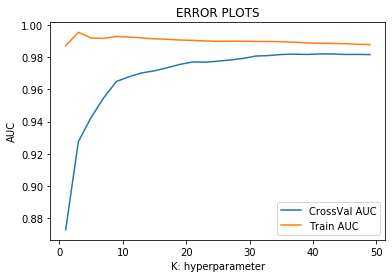

In [0]:
plt.plot(neighbour, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.plot(neighbour, Train_AUC_BOW, label='Train AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_k)

43


In [0]:
Classifier=KNeighborsClassifier(n_neighbors=optimal_k)
Classifier.fit(X_train_counts, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=43, p=2,
                     weights='uniform')

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_train,Classifier.predict(X_train_counts))
print (Train_mat)

Confusion Matrix of Train Data
[[577   3   6  32  18   2   7   0  18  86]
 [  2 317   0  18   0   0   1   0 196  24]
 [  3   2 437  17   3   0   3   0   3  43]
 [  1   1   0 544   5   3   1   0   0   6]
 [  0   1   0  16 404   0   1   3   3  20]
 [  1   0   0  18  26 518   2   0   1  71]
 [  6   1   0  20   6   0 491   0   1  23]
 [  0   5   9  18   0   0   0 485   0  62]
 [  5  27   0  19   4   3   1   0 387  38]
 [  0   1   1  11  13   0   0   2   0 545]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_train,Classifier.predict(X_train_counts), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.97      0.77      0.86       749
     science       0.89      0.57      0.69       558
        vlog       0.96      0.86      0.91       511
        food       0.76      0.97      0.85       561
     fashion       0.84      0.90      0.87       448
      travel       0.98      0.81      0.89       637
       music       0.97      0.90      0.93       548
      movies       0.99      0.84      0.91       579
     history       0.64      0.80      0.71       484
         art       0.59      0.95      0.73       573

    accuracy                           0.83      5648
   macro avg       0.86      0.84      0.84      5648
weighted avg       0.87      0.83      0.84      5648



In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test,Classifier.predict(X_test_counts))
print (Test_mat)

Confusion Matrix of Test Data
[[264   2   1  25  15   1   1   0  12  36]
 [  1 142   1   7   1   3   1   0 110   7]
 [  2   0 188  10   1   0   0   0   3  19]
 [  0   0   2 195   7   0   0   1   2   1]
 [  2   0   0   3 200   0   1   1   0   5]
 [  1   2   0  13  17 221   1   0   0  23]
 [  2   0   0  11   3   0 194   0   0   9]
 [  0   2   5   9   1   0   0 208   0  32]
 [  1   9   0  12   0   1   1   1 192  15]
 [  0   0   2  12   6   0   1   1   1 229]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test,Classifier.predict(X_test_counts), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.97      0.74      0.84       357
     science       0.90      0.52      0.66       273
        vlog       0.94      0.84      0.89       223
        food       0.66      0.94      0.77       208
     fashion       0.80      0.94      0.86       212
      travel       0.98      0.79      0.88       278
       music       0.97      0.89      0.93       219
      movies       0.98      0.81      0.89       257
     history       0.60      0.83      0.70       232
         art       0.61      0.91      0.73       252

    accuracy                           0.81      2511
   macro avg       0.84      0.82      0.81      2511
weighted avg       0.85      0.81      0.81      2511



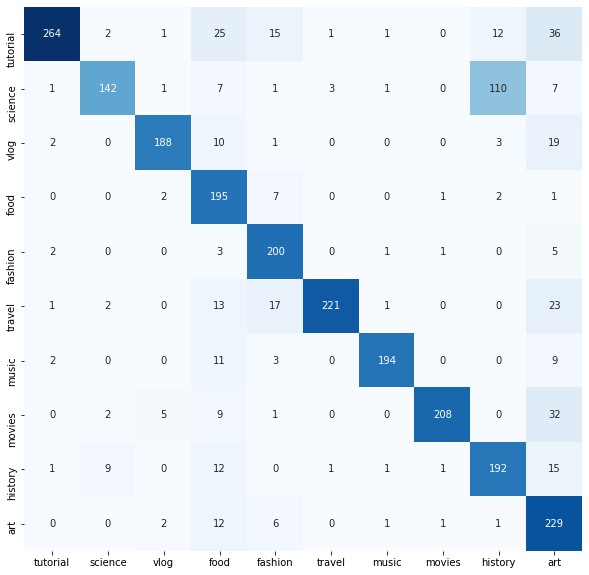

In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(Test_mat, annot=True, cbar=False, fmt='g',cmap='Blues', xticklabels=ticks, yticklabels=ticks)

In [0]:
ticks = df['category'].unique()

In [0]:
recall = np.diag(Test_mat) / np.sum(Test_mat, axis = 1)
precision = np.diag(Test_mat) / np.sum(Test_mat, axis = 0)

In [0]:
from sklearn.metrics import precision_recall_curve

In [0]:
plt.figure(figsize=(10,10))
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")

plt.show()

Weighted KNN 
implementation on same dataset

In [0]:
from sklearn.neighbors import KNeighborsClassifier

#import metrics model to check the accuracy 
from sklearn import metrics
Mylist=list(range(50))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_BOW = []
CrossVal_AUC_BOW = []

for k in neighbour:
        knn = KNeighborsClassifier(n_neighbors=k,  weights='distance')
        knn.fit(X_train_counts, y_train)
        y_train_pred=knn.predict_proba(X_train_counts)[0:,]
        Train_AUC_BOW.append(roc_auc_score(y_train,y_train_pred, multi_class='ovr'))
        CrossVal_y_pred = knn.predict_proba(X_cross_counts)[0:,]
        CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred,  multi_class='ovr'))

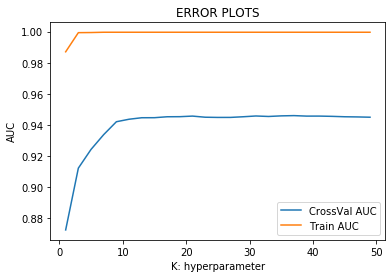

In [0]:
plt.plot(neighbour, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.plot(neighbour, Train_AUC_BOW, label='Train AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_k)

37


In [0]:
Classifier=KNeighborsClassifier(n_neighbors=optimal_k)
Classifier.fit(X_train_counts, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                     weights='uniform')

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_train,Classifier.predict(X_train_counts))
print (Train_mat)

Confusion Matrix of Train Data
[[582   5   6  26  18   2   8   0  17  85]
 [  3 331   0  16   0   0   1   0 190  17]
 [  3   2 443  12   2   0   3   0   4  42]
 [  1   1   0 543   6   3   1   0   0   6]
 [  0   2   0  12 411   0   0   1   1  21]
 [  0   1   0  15  25 527   0   0   0  69]
 [  6   1   0  17   5   0 493   0   1  25]
 [  0   5  10  11   0   0   0 485   0  68]
 [  3  30   0  19   4   3   1   0 389  35]
 [  0   1   1  11  10   0   0   1   0 549]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_train,Classifier.predict(X_train_counts), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.97      0.78      0.86       749
     science       0.87      0.59      0.71       558
        vlog       0.96      0.87      0.91       511
        food       0.80      0.97      0.87       561
     fashion       0.85      0.92      0.88       448
      travel       0.99      0.83      0.90       637
       music       0.97      0.90      0.93       548
      movies       1.00      0.84      0.91       579
     history       0.65      0.80      0.72       484
         art       0.60      0.96      0.74       573

    accuracy                           0.84      5648
   macro avg       0.87      0.84      0.84      5648
weighted avg       0.87      0.84      0.85      5648



In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test,Classifier.predict(X_test_counts))
print (Test_mat)

Confusion Matrix of Test Data
[[264   1   1  19  14   1   2   0   9  46]
 [  1 136   0   8   1   3   1   0 115   8]
 [  1   1 192   8   0   0   0   0   3  18]
 [  0   1   2 194   7   0   0   1   0   3]
 [  1   0   0   3 200   0   0   1   0   7]
 [  0   0   0   5  17 220   1   0   0  35]
 [  0   1   0   9   3   0 195   0   0  11]
 [  0   2   5   7   1   0   0 206   0  36]
 [  1  12   0  10   0   1   1   1 189  17]
 [  0   1   3  11   4   0   1   0   1 231]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test,Classifier.predict(X_test_counts), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.99      0.74      0.84       357
     science       0.88      0.50      0.64       273
        vlog       0.95      0.86      0.90       223
        food       0.71      0.93      0.80       208
     fashion       0.81      0.94      0.87       212
      travel       0.98      0.79      0.87       278
       music       0.97      0.89      0.93       219
      movies       0.99      0.80      0.88       257
     history       0.60      0.81      0.69       232
         art       0.56      0.92      0.70       252

    accuracy                           0.81      2511
   macro avg       0.84      0.82      0.81      2511
weighted avg       0.85      0.81      0.81      2511



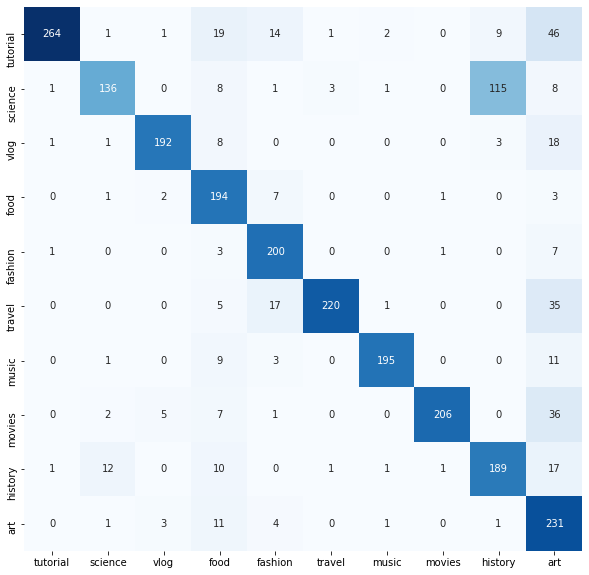

In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(Test_mat, annot=True, cbar=False, fmt='g',cmap='Blues', xticklabels=ticks, yticklabels=ticks)

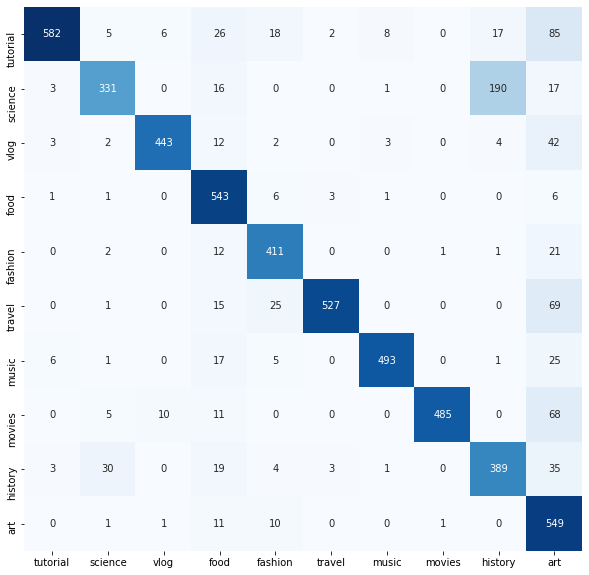

In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(Train_mat, annot=True, cbar=False, fmt='g',cmap='Blues', xticklabels=ticks, yticklabels=ticks)

***KD-Tree implementation of KNN***

In [0]:
X_train_counts_arr=X_train_counts.toarray()
X_cross_counts_arr=X_cross_counts.toarray()
X_test_counts_arr=X_test_counts.toarray()

In [0]:
standardized_vec = StandardScaler(with_mean=False)
standardized_vec.fit(X_train_counts_arr)

StandardScaler(copy=True, with_mean=False, with_std=True)

In [0]:
X_train_counts_std=standardized_vec.transform(X_train_counts_arr)
X_cross_counts_std=standardized_vec.transform(X_cross_counts_arr)
X_test_counts_std=standardized_vec.transform(X_test_counts_arr)

In [0]:
Mylist=list(range(30, 50))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in neighbour:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
  neigh.fit(X_train_counts_std, y_train)
  print(i)
  Train_y_pred =  neigh.predict_proba(X_train_counts_std)[0:,]
  Train_AUC_BOW.append(roc_auc_score(y_train, Train_y_pred, multi_class='ovr'))
  print(i)
  CrossVal_y_pred =  neigh.predict_proba(X_cross_counts_std)[0:,]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross, CrossVal_y_pred, multi_class='ovr'))

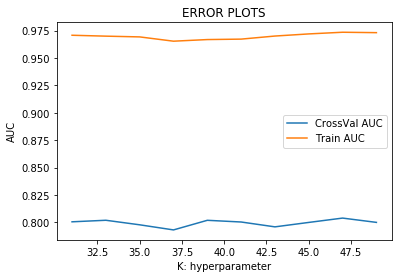

In [0]:
plt.plot(neighbour, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.plot(neighbour, Train_AUC_BOW, label='Train AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_k)

47


In [0]:
Classifier=KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
Classifier.fit(X_train_counts_std, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform')

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_train,Classifier.predict(X_train_counts_std))
print (Train_mat)

Confusion Matrix of Train Data
[[  1   0   3   0   6   0  47   0   0 692]
 [  0  24   1   0   1   0   4   0   0 528]
 [  0   0 275   0   1   0   4   0   0 231]
 [  0   0   2  12   2   0   2   0   0 543]
 [  0   0   0   0 112   0   1   0   0 335]
 [  0   0   0   0   3   0   0   0   0 634]
 [  0   0   2   0   1   0 469   0   0  76]
 [  0   0  16   0   0   0   5   4   0 554]
 [  1   0   1   0   0   0   6   0   0 476]
 [  0   0   3   0   0   0   2   0   0 568]]


In [0]:
y_pred = Classifier.predict_proba(X_test_counts_std)[0:,]
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

In [0]:
from sklearn.preprocessing import LabelBinarizer
multiclass_roc_auc_score(y_test,y_pred)

In [0]:
train_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(train_mat, annot=True, cbar=False, fmt='g',cmap='Blues', xticklabels=ticks, yticklabels=ticks)